In [1]:
# packages

import importlib_resources
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import svd
from itertools import combinations
import xlrd
from matplotlib.patches import Ellipse
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import zscore

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from dtuimldmtools import rlr_validate
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_predict, KFold
from sklearn.neural_network import MLPRegressor
from dtuimldmtools import draw_neural_net, train_neural_net
import torch

import os
os.chdir(os.path.abspath(''))

## PART A

In [66]:
filename = 'Raisin_Dataset.xls'
doc = xlrd.open_workbook(filename).sheet_by_index(0)


attributeNames = doc.row_values(0, 0, 7)

classLabels = doc.col_values(7, 1, 901)
classNames = sorted(set(classLabels))
classDict = dict(zip(classNames, range(len(classNames))))

# Extract vector y, convert to NumPy array
y = np.asarray([classDict[value] for value in classLabels])

# Preallocate memory, then extract excel data to matrix X
X = np.empty((900, 7))
for i, col_id in enumerate(range(0, 7)):
    X[:, i] = np.asarray(doc.col_values(col_id, 1, 901))

# Compute values of N, M and C
N = len(y)
M = len(attributeNames)
C = len(classNames)

print(f'matrix size: {N} by {M}')
print(attributeNames)
print(classNames)


# eccentricity and first class
selected_feature = attributeNames[3]
y = X[:,3]
X = np.delete(X, 3, axis=1)
attributeNames.pop(3)

print('selected: ', selected_feature)

# regularization
mu = np.mean(X, 0)
sigma = np.std(X, 0)
X = (X - mu) / sigma

mu2 = np.mean(y)
sigma2 = np.std(y)
y = (y - mu2) / sigma2

# Add offset attribute
X = np.concatenate((np.ones((X.shape[0], 1)), X), 1)
attributeNames = ["Offset"] + attributeNames
M = M

print(f'matrix size: {N} by {M}')
print(attributeNames)


matrix size: 900 by 7
['Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'ConvexArea', 'Extent', 'Perimeter']
['Besni', 'Kecimen']
selected:  Eccentricity
matrix size: 900 by 7
['Offset', 'Area', 'MajorAxisLength', 'MinorAxisLength', 'ConvexArea', 'Extent', 'Perimeter']


optimal lambda = 0.08685113737513529 with error = 0.19862365492178075
Weights:
	Offset              : 0.00000
	Area                : 2.64446
	MajorAxisLength     : 0.90144
	MinorAxisLength     : -1.21909
	ConvexArea          : -2.68403
	Extent              : 0.00195
	Perimeter           : 0.65423


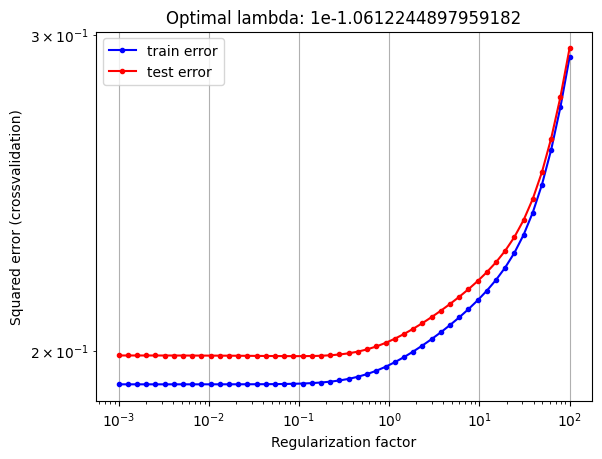

In [67]:
# using rlr_validate

# parameters
#lambdas = np.power(10.0, range(-5, 9))
lambdas = np.logspace(-3, 2, 50)
cross_validation = 10
XtX = X.T @ X
Xty = X.T @ y

(   opt_val_err,
    opt_lambda,
    mean_w_vs_lambda,
    train_err_vs_lambda,
    test_err_vs_lambda,
    ) = rlr_validate(X, y, lambdas, cross_validation)

lambdaI = opt_lambda * np.eye(M)
lambdaI[0, 0] = 0  # Do no regularize the bias term
w_rlr= np.linalg.solve(XtX + lambdaI, Xty).squeeze()
print(f'optimal lambda = {opt_lambda} with error = {opt_val_err}')

print("Weights:")
for m in range(M):
    print(f'\t{attributeNames[m].ljust(20)}: {w_rlr[m]:.5f}')

plt.figure()
plt.title("Optimal lambda: 1e{0}".format(np.log10(opt_lambda)))
plt.loglog(lambdas, train_err_vs_lambda.T, "b.-", label='train error')
plt.loglog(lambdas, test_err_vs_lambda.T, "r.-", label='test error')
plt.xlabel("Regularization factor")
plt.ylabel("Squared error (crossvalidation)")
plt.legend()
plt.grid()


plt.show()

Optimal lambda: 0.10985411419875583
Weights:
	Offset              : 0.00000
	Area                : 2.47879
	MajorAxisLength     : 0.95919
	MinorAxisLength     : -1.19412
	ConvexArea          : -2.50834
	Extent              : 0.00197
	Perimeter           : 0.56473


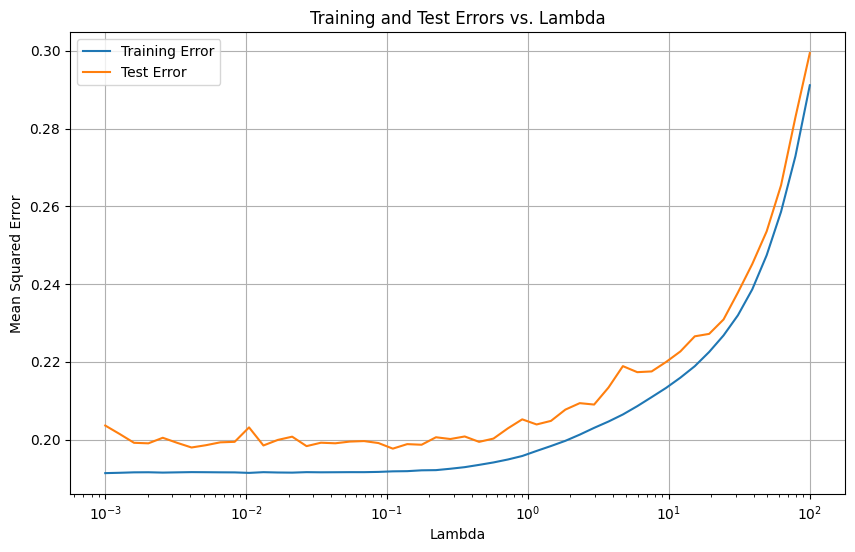

In [65]:
# changing the solution method but same result

# parameters
K = 10
CV = model_selection.KFold(n_splits=K, shuffle=True)
lambdas = np.logspace(-3, 2, 50)

# Initialize arrays to store errors
Error_train = np.zeros(len(lambdas))
Error_test = np.zeros(len(lambdas))

# Loop over lambda values
for i, lambda_val in enumerate(lambdas):
    # Initialize arrays to store fold errors
    fold_train_errors = []
    fold_test_errors = []
    
    # Perform cross-validation
    for train_index, test_index in CV.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Train Ridge regression model with current lambda value
        model = Ridge(alpha=lambda_val)
        model.fit(X_train, y_train)

        # Compute training error
        train_error = np.mean((y_train - model.predict(X_train))**2)
        fold_train_errors.append(train_error)

        # Compute test error
        test_error = np.mean((y_test - model.predict(X_test))**2)
        fold_test_errors.append(test_error)

    # Average fold errors
    Error_train[i] = np.mean(fold_train_errors)
    Error_test[i] = np.mean(fold_test_errors)

optimal_lambda_index = np.argmin(Error_test)
optimal_lambda = lambdas[optimal_lambda_index]

print(f'Optimal lambda: {optimal_lambda}')

model = Ridge(alpha=optimal_lambda)
model.fit(X, y)

# Get the weights of the parameters
weights = model.coef_

print("Weights:")
for m in range(M):
    print(f'\t{attributeNames[m].ljust(20)}: {w_rlr[m]:.5f}')


# Plot training and test errors
plt.figure(figsize=(10, 6))
plt.semilogx(lambdas, Error_train, label='Training Error')
plt.semilogx(lambdas, Error_test, label='Test Error')
plt.xlabel('Lambda')
plt.ylabel('Mean Squared Error')
plt.title('Training and Test Errors vs. Lambda')
plt.legend()
plt.grid(True)
plt.show()



# PART B

In [2]:
filename = 'Raisin_Dataset.xls'
doc = xlrd.open_workbook(filename).sheet_by_index(0)


attributeNames = doc.row_values(0, 0, 7)

classLabels = doc.col_values(7, 1, 901)
classNames = sorted(set(classLabels))
classDict = dict(zip(classNames, range(len(classNames))))

# Extract vector y, convert to NumPy array
y = np.asarray([classDict[value] for value in classLabels])

# Preallocate memory, then extract excel data to matrix X
X = np.empty((900, 7))
for i, col_id in enumerate(range(0, 7)):
    X[:, i] = np.asarray(doc.col_values(col_id, 1, 901))

# Compute values of N, M and C
N = len(y)
M = len(attributeNames)
C = len(classNames)

print('original')
print(f'matrix size: {N} by {M}')
print(attributeNames)
print(classNames)


# eccentricity and first class
selected_feature = attributeNames[3]
y = X[:,3]
X = np.delete(X, 3, axis=1)
attributeNames.pop(3)

print('selected: ', selected_feature)

# no regularization

# Add offset attribute
X = np.concatenate((np.ones((X.shape[0], 1)), X), 1)
attributeNames = ["Offset"] + attributeNames
M = M

print(f'matrix size: {N} by {M}')
print(attributeNames)


original
matrix size: 900 by 7
['Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'ConvexArea', 'Extent', 'Perimeter']
['Besni', 'Kecimen']
selected:  Eccentricity
matrix size: 900 by 7
['Offset', 'Area', 'MajorAxisLength', 'MinorAxisLength', 'ConvexArea', 'Extent', 'Perimeter']


In [3]:
def compute_error_rate(y_true, y_pred):
    return np.sum(y_true - y_pred)**2 / len(y_true)

optimal lambda = 0.054286754393238594 with error = 0.0016280659922006935
Weights:
	Offset              : 0.78843
	Area                : 0.00001
	MajorAxisLength     : 0.00065
	MinorAxisLength     : -0.00226
	ConvexArea          : -0.00001
	Extent              : 0.00328
	Perimeter           : 0.00025


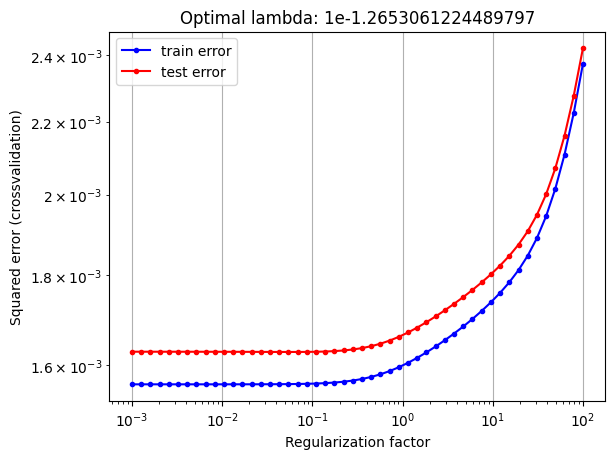

In [4]:
# apply linear regression on the data

lambdas = np.logspace(-3, 2, 50)
cross_validation = 10
XtX = X.T @ X
Xty = X.T @ y

(   opt_val_err,
    opt_lambda,
    mean_w_vs_lambda,
    train_err_vs_lambda,
    test_err_vs_lambda,
    ) = rlr_validate(X, y, lambdas, cross_validation)

lambdaI = opt_lambda * np.eye(M)
lambdaI[0, 0] = 0  # Do no regularize the bias term
w_rlr= np.linalg.solve(XtX + lambdaI, Xty).squeeze()
print(f'optimal lambda = {opt_lambda} with error = {opt_val_err}')

print("Weights:")
for m in range(M):
    print(f'\t{attributeNames[m].ljust(20)}: {w_rlr[m]:.5f}')

plt.figure()
plt.title("Optimal lambda: 1e{0}".format(np.log10(opt_lambda)))
plt.loglog(lambdas, train_err_vs_lambda.T, "b.-", label='train error')
plt.loglog(lambdas, test_err_vs_lambda.T, "r.-", label='test error')
plt.xlabel("Regularization factor")
plt.ylabel("Squared error (crossvalidation)")
plt.legend()
plt.grid()


plt.show()

In [3]:
# apply ANN


# Normalize data
#X = stats.zscore(X)


# Parameters for neural network classifier
n_hidden_units = 2  # number of hidden units
n_replicates = 1  # number of networks trained in each k-fold
max_iter = 1000

nodes_range = range(1, 15)

# K-fold crossvalidation
K = 5
CV = model_selection.KFold(K, shuffle=True)

# ANN model
model = lambda: torch.nn.Sequential(
    torch.nn.Linear(M, n_hidden_units),  # M features to n_hidden_units
    torch.nn.Tanh(),  # 1st transfer function,
    torch.nn.Linear(n_hidden_units, 1),  # n_hidden_units to 1 output neuron
    )
loss_fn = torch.nn.MSELoss()  # notice how this is now a mean-squared-error loss

error = []
for k, (train_index, test_index) in enumerate(CV.split(X, y)):
    print("\nCrossvalidation fold: {0}/{1}".format(k + 1, K))

    X_train = torch.Tensor(X[train_index, :])
    y_train = torch.Tensor(y[train_index])
    X_test = torch.Tensor(X[test_index, :])
    y_test = torch.Tensor(y[test_index])

    net, final_loss, learning_curve = train_neural_net(
        model,
        loss_fn,
        X=X_train,
        y=y_train,
        n_replicates=n_replicates,
        max_iter=max_iter,
    )

    y_test_est = net(X_test)
    se = (y_test_est.float() - y_test.float()) ** 2  # squared error
    mse = (sum(se).type(torch.float) / len(y_test)).data.numpy()  # mean
    error.append(mse)  # store error rate for current CV fold

ANN_error = np.mean(error)

print('error', ANN_error)
print('nodes', n_hidden_units)





Crossvalidation fold: 1/5

	Replicate: 1/1
		Iter	Loss			Rel. loss


d:\anaconda\envs\myenv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([720])) that is different to the input size (torch.Size([720, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


		1000	0.20683762	0.0045929328
		Final loss:
		1000	0.20683762	0.0045929328

Crossvalidation fold: 2/5

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.008547923	0.00032413928
		Final loss:
		1000	0.008547923	0.00032413928

Crossvalidation fold: 3/5

	Replicate: 1/1
		Iter	Loss			Rel. loss
		Final loss:
		785	0.007841511	9.501452e-07

Crossvalidation fold: 4/5

	Replicate: 1/1
		Iter	Loss			Rel. loss
		Final loss:
		321	0.0076894737	7.2669883e-07

Crossvalidation fold: 5/5

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.008194305	8.751347e-06
		Final loss:
		1000	0.008194305	8.751347e-06
error 0.048019037
nodes 2


In [17]:
# apply ANN


# Normalize data
#X = stats.zscore(X)


# Parameters for neural network classifier
#n_hidden_units = 2  # number of hidden units
n_replicates = 1  # number of networks trained in each k-fold
max_iter = 1000

nodes_range = range(1, 10)
ANN_error = []

# K-fold crossvalidation
K = 5
CV = model_selection.KFold(K, shuffle=True)

for n in nodes_range:
    print(f'iteration {n}/{len(nodes_range)}')
    model = lambda: torch.nn.Sequential(
        torch.nn.Linear(M, n),  # M features to n_hidden_units
        torch.nn.Tanh(),  # 1st transfer function,
        torch.nn.Linear(n, 1),  # n_hidden_units to 1 output neuron
        )
    loss_fn = torch.nn.MSELoss()  # notice how this is now a mean-squared-error loss

    error = []
    for k, (train_index, test_index) in enumerate(CV.split(X, y)):
        print("\nCrossvalidation fold: {0}/{1}".format(k + 1, K))

        X_train = torch.Tensor(X[train_index, :])
        y_train = torch.Tensor(y[train_index])
        X_test = torch.Tensor(X[test_index, :])
        y_test = torch.Tensor(y[test_index])

        net, final_loss, learning_curve = train_neural_net(
            model,
            loss_fn,
            X=X_train,
            y=y_train,
            n_replicates=n_replicates,
            max_iter=max_iter,
        )

        y_test_est = net(X_test)
        se = (y_test_est.float() - y_test.float()) ** 2  # squared error
        mse = (sum(se).type(torch.float) / len(y_test)).data.numpy()  # mean
        error.append(mse)  # store error rate for current CV fold

    ANN_error.append(np.mean(error))

min_error_idx = np.argmin(ANN_error)
min_error = ANN_error[min_error_idx]
optimal_nodes = nodes_range[min_error_idx]

print('error', min_error)
print('nodes', optimal_nodes)





iteration 1/9

Crossvalidation fold: 1/5

	Replicate: 1/1
		Iter	Loss			Rel. loss


d:\anaconda\envs\myenv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([720])) that is different to the input size (torch.Size([720, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


		1000	0.018682327	0.0041460497
		Final loss:
		1000	0.018682327	0.0041460497

Crossvalidation fold: 2/5

	Replicate: 1/1
		Iter	Loss			Rel. loss
		Final loss:
		689	0.0081300745	9.1642136e-07

Crossvalidation fold: 3/5

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.51523316	0.002947151
		Final loss:
		1000	0.51523316	0.002947151

Crossvalidation fold: 4/5

	Replicate: 1/1
		Iter	Loss			Rel. loss
		Final loss:
		349	0.007996075	9.3177886e-07

Crossvalidation fold: 5/5

	Replicate: 1/1
		Iter	Loss			Rel. loss


KeyboardInterrupt: 

In [11]:
# modified very slow

folds=10

cv_model = model_selection.KFold(n_splits=folds, shuffle=True)
outer_results = []
lambdas = np.logspace(-3, 2, 50)
nodes_range = range(1, 12)
n_replicates = 1  # number of networks trained in each k-fold
max_iter = 1000


# GridSearchCV for Linear Regression and KNN at the same time
for i, (train_index, test_index) in enumerate(cv_model.split(X, y), start=1):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # linear regression
    (   opt_err_reg,
        opt_lambda,
        mean_w_vs_lambda,
        train_err_vs_lambda,
        test_err_vs_lambda,
        ) = rlr_validate(X_train, y_train, lambdas, folds)


    ## ANN
    ANN_error = []

    for n in nodes_range:
        print(f'outer fold {i}/{folds}')
        print(f'node iteration {n}/{len(nodes_range)}')

        model = lambda: torch.nn.Sequential(
            torch.nn.Linear(M, n),  # M features to n_hidden_units
            torch.nn.Tanh(),  # 1st transfer function,
            torch.nn.Linear(n, 1),  # n_hidden_units to 1 output neuron
            )
        loss_fn = torch.nn.MSELoss()  # notice how this is now a mean-squared-error loss

        error = []
        for k, (train_index_in, test_index_in) in enumerate(cv_model.split(X_train, y_train)):
            print(f'Crossvalidation fold: {k}/{folds}')

            X_train_in = torch.Tensor(X[train_index_in, :])
            y_train_in = torch.Tensor(y[train_index_in])
            X_test_in = torch.Tensor(X[test_index_in, :])
            y_test_in = torch.Tensor(y[test_index_in])

            net, final_loss, learning_curve = train_neural_net(
                model,
                loss_fn,
                X=X_train_in,
                y=y_train_in,
                n_replicates=n_replicates,
                max_iter=max_iter,
            )

            y_test_est = net(X_test_in)
            se = (y_test_est.float() - y_test_in.float()) ** 2  # squared error
            mse = (sum(se).type(torch.float) / len(y_test_in)).data.numpy()  # mean
            error.append(mse)  # store error rate for current CV fold

        ANN_error.append(np.mean(error))
    min_error_idx = np.argmin(ANN_error)
    min_error_ANN = ANN_error[min_error_idx]
    optimal_nodes = nodes_range[min_error_idx]

    #Evaluation Baseline
    y_pred_baseline = np.ones(len(y_test))*np.mean(y_train)
    error_rate_baseline = compute_error_rate(y_test, y_pred_baseline)
    
    #Results
    outer_results.append({
        'Outer_Fold': i,
        'ANN_Param': optimal_nodes,
        'ANN_Error': min_error_ANN * 100,
        'LogReg_lam_Param': opt_lambda,
        'LogReg_Error': opt_err_reg * 100,
        'Baseline_Error': error_rate_baseline * 100
    })

#Display
results_panda = pd.DataFrame(outer_results)
print(results_panda)




outer fold 1/10
node iteration 1/11
Crossvalidation fold: 0/10

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.53476125	0.0029150809
		Final loss:
		1000	0.53476125	0.0029150809
Crossvalidation fold: 1/10

	Replicate: 1/1
		Iter	Loss			Rel. loss
		Final loss:
		677	0.00787582	9.460061e-07
Crossvalidation fold: 2/10

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.067274295	0.004624009
		Final loss:
		1000	0.067274295	0.004624009
Crossvalidation fold: 3/10

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.11924461	0.004234545
		Final loss:
		1000	0.11924461	0.004234545
Crossvalidation fold: 4/10

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.0083092805	1.5691486e-06
		Final loss:
		1000	0.0083092805	1.5691486e-06
Crossvalidation fold: 5/10

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.44915894	0.0030653647
		Final loss:
		1000	0.44915894	0.0030653647
Crossvalidation fold: 6/10

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.058927123	0.004669295
		Final loss:
		1000	0.058927

In [ ]:
# original lambda

def compute_error_rate(y_true, y_pred):
    return np.sum(y_true - y_pred)**2 / len(y_true)

folds=5

cv_model = model_selection.KFold(n_splits=folds, shuffle=True)
outer_results = []
nodes_range = range(1, 15)
ANN_results = {'nodes': [], 'error': []}


# GridSearchCV for Linear Regression and KNN at the same time
for i, (train_index, test_index) in enumerate(cv_model.split(X, y), start=1):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Linear Regression with GridSearch
    lin_reg = Ridge()
    #param_grid_lin_reg = {'alpha': [0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18]}
    #param_grid_lin_reg = {'alpha': [0.001, 0.010, 0.015, 0.020, 0.025, 0.030, 0.040, 0.050]}
    param_grid_lin_reg = {'alpha': [0.001, 0.010, 0.015, 0.020, 0.025, 0.030, 0.040, 0.050, 0.060, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3]}
    grid_search_lin_reg = GridSearchCV(lin_reg, param_grid_lin_reg, cv=folds)
    grid_search_lin_reg.fit(X_train, y_train)
    best_lin_reg = grid_search_lin_reg.best_estimator_
    best_lin_reg.fit(X_train, y_train)
    y_pred_lin_reg = best_lin_reg.predict(X_test)
    error_rate_lin_reg = compute_error_rate(y_test, y_pred_lin_reg)


    ## ANN
    for h in nodes_range:
        # Initialize error list for each h
        errors = []
        
        # Inner cross-validation
        for train_index, test_index in cv_model.split(X_train, y_train):
            X_train_in, X_test_in = X_train[train_index], X_train[test_index]
            y_train_in, y_test_in = y_train[train_index], y_train[test_index]
            
            # Create and train MLPRegressor with 1 hidden layer and h nodes
            mlp = MLPRegressor(hidden_layer_sizes=(h,), max_iter=4000)
            mlp.fit(X_train_in, y_train_in)
            
            # Predictions
            y_pred_ANN = mlp.predict(X_test_in)
            
            # Calculate mean squared error
            error_rate_ANN = compute_error_rate(y_test_in, y_pred_ANN)
            errors.append(error_rate_ANN)
        
        # Store average error for this h
        ANN_results['nodes'].append(h)
        ANN_results['error'].append(np.mean(errors))

    optimal_nodes = ANN_results['nodes'][np.argmin(ANN_results['error'])]
    min_error = np.min(ANN_results['error'])

    #Evaluation Baseline
    y_pred_baseline = np.ones(len(y_test))*np.mean(y_train)
    print('mean y', np.mean(y_train))
    error_rate_baseline = compute_error_rate(y_test, y_pred_baseline)
    
    #Results
    outer_results.append({
        'Outer_Fold': i,
        'ANN_Param': optimal_nodes,
        'ANN_Error': min_error * 100,
        'LogReg_C_Param': grid_search_lin_reg.best_params_['alpha'],
        'LogReg_Error': error_rate_lin_reg * 100,
        'Baseline_Error': error_rate_baseline * 100
    })

    print(f'fold{i}/{folds} computed')


#Display
results_panda = pd.DataFrame(outer_results)
print(results_panda)




In [9]:
print(results_panda['Baseline_Error'])

NameError: name 'results_panda' is not defined

In [8]:
# LogReg vs ANN
t_lr_ann, p_lr_ann = stats.ttest_rel(results_panda['LogReg_Error'], results_panda['ANN_Error'])
cin_lr_ann = stats.t.interval(0.91, len(results_panda['LogReg_Error'])-1, loc=np.mean(results_panda['LogReg_Error']-results_panda['ANN_Error']), scale=stats.sem(results_panda['LogReg_Error']-results_panda['ANN_Error']))
print(f"LR - ANN: p = {p_lr_ann}, CI = {cin_lr_ann}")
# LogReg vs Baseline
t_lr_baseline, p_lr_baseline = stats.ttest_rel(results_panda['LogReg_Error'], results_panda['Baseline_Error'])
cin_lr_baseline = stats.t.interval(0.91, len(results_panda['LogReg_Error'])-1, loc=np.mean(results_panda['LogReg_Error']-results_panda['Baseline_Error']), scale=stats.sem(results_panda['LogReg_Error']-results_panda['Baseline_Error']))
print(f"LR - Baseline: p = {p_lr_baseline}, CI = {cin_lr_baseline}")
# ANN vs Baseline
t_ann_baseline, p_ann_baseline = stats.ttest_rel(results_panda['ANN_Error'], results_panda['Baseline_Error'])
cin_ann_baseline = stats.t.interval(0.91, len(results_panda['ANN_Error'])-1, loc=np.mean(results_panda['ANN_Error']-results_panda['Baseline_Error']), scale=stats.sem(results_panda['ANN_Error']-results_panda['Baseline_Error']))
print(f"ANN - Baseline: p = {p_ann_baseline}, CI = {cin_ann_baseline}")

NameError: name 'results_panda' is not defined